In [ ]:
pip install transformers

In [25]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [26]:
df = pd.read_csv("/content/hogwarts_legacy_reviews.csv")
df = df.drop(['Unnamed: 0'], axis=1)

In [27]:
df = df.head(1000)

In [28]:
df.head()

,Playtime,Feedback,Review
0,16,Positive,Greattt Game!
1,26,Positive,9/10Fantastic experience. A true Wizarding Wor...
2,29,Positive,worth it
3,24,Positive,I've been waiting 84 YEARSSSSSSSS.The game is ...
4,7,Positive,very fun game (it is not transphobic at all)


In [29]:
example = df.iloc[80]['Review']

In [30]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [31]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
      #'id': df.index[df['Review'] == example][0],
      'roberta_neg' : scores[0],
      'roberta_neu' : scores[1],
      'roberta_pos' : scores[2],
      'Review' : example
  }
  return scores_dict

In [32]:
roberta_result = {}

for i, row in df.iterrows():
  try:
    text = row['Review']
    roberta_result[i] = polarity_scores_roberta(text)
  except RuntimeError:
    print(f'error at', i)

error at 30
error at 116
error at 155
error at 413
error at 487
error at 787


In [33]:
result_df = pd.DataFrame(roberta_result)

In [34]:
result_df = result_df.T
result_df.head()

,roberta_neg,roberta_neu,roberta_pos,Review
0,0.002688,0.024788,0.972525,Greattt Game!
1,0.002785,0.029467,0.967748,9/10Fantastic experience. A true Wizarding Wor...
2,0.116993,0.573539,0.309468,worth it
3,0.008601,0.033362,0.958037,I've been waiting 84 YEARSSSSSSSS.The game is ...
4,0.00922,0.06757,0.92321,very fun game (it is not transphobic at all)


In [35]:
combined_dataframe = pd.merge(result_df, df, on='Review', how='inner')

In [36]:
combined_dataframe.head()

,roberta_neg,roberta_neu,roberta_pos,Review,Playtime,Feedback
0,0.002688,0.024788,0.972525,Greattt Game!,16,Positive
1,0.002785,0.029467,0.967748,9/10Fantastic experience. A true Wizarding Wor...,26,Positive
2,0.116993,0.573539,0.309468,worth it,29,Positive
3,0.008601,0.033362,0.958037,I've been waiting 84 YEARSSSSSSSS.The game is ...,24,Positive
4,0.00922,0.06757,0.92321,very fun game (it is not transphobic at all),7,Positive


In [37]:
combined_dataframe.columns

Index(['roberta_neg', 'roberta_neu', 'roberta_pos', 'Review', 'Playtime',
       'Feedback'],
      dtype='object')

In [38]:
combined_dataframe['Result'] = combined_dataframe.apply(lambda x: 'Positive' if x['roberta_pos'] > x['roberta_neg'] else 'Negative', axis=1)


In [39]:
y_test = combined_dataframe['Feedback']
y_pred = combined_dataframe['Result']

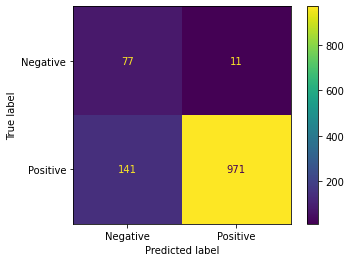

In [40]:
 ConfusionMatrixDisplay.from_predictions(y_test, y_pred)